/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.2474 - loss: 213.8160 - val_accuracy: 0.4667 - val_loss: 558.6808
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.5169 - loss: 539.6589 - val_accuracy: 0.4667 - val_loss: 448.9737
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5243 - loss: 381.2145 - val_accuracy: 0.5333 - val_loss: 283.6793
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5390 - loss: 271.8086 - val_accuracy: 0.5333 - val_loss: 178.2139
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6126 - loss: 174.0105 - val_accuracy: 0.4333 - val_loss: 61.6455
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.7106 - loss: 50.2489 - val_accuracy: 0.5333 - val_loss: 88.7576
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6248 - loss: 54.4111 - val_accuracy: 0.5000 - val_loss: 68.1209
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6863 - loss: 35.7903 - val_accuracy: 0.5000 - v

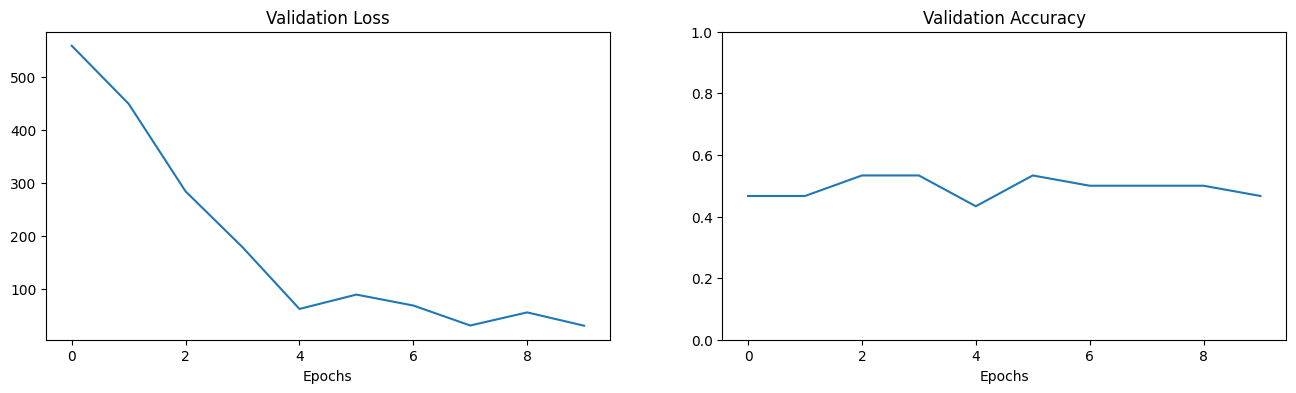

Test loss: 26.184900283813477
Test accuracy: 0.7666666507720947


In [1]:
# -*- coding: utf-8 -*-
"""
# Projeto de Classificação de Imagens com Redes Neurais Convolucionais (CNN)

Este código implementa um classificador de imagens utilizando uma Rede Neural Convolucional (CNN) em Keras. O objetivo é carregar um conjunto de imagens, processá-las, treinar um modelo CNN e avaliar o desempenho do modelo em um conjunto de dados de teste.

## Passos:
1. Carregamento e pré-processamento de imagens
2. Criação do modelo CNN
3. Treinamento do modelo com EarlyStopping
4. Avaliação do modelo
5. Exibição dos gráficos de perda e acurácia durante o treinamento
6. Aumento de dados (Data Augmentation) para melhorar a generalização do modelo
"""

import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
from keras.utils import to_categorical

# Função para remover arquivos não-jpg
def remove_non_jpg_files(directory):
    """
    Remove arquivos que não são do tipo JPG dentro de um diretório.

    Parâmetros:
    directory (str): Caminho para o diretório onde os arquivos serão verificados.
    """
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and not filename.lower().endswith(".jpg"):
            try:
                os.remove(file_path)
                print(f"Removed: {file_path}")
            except OSError as e:
                print(f"Error removing file {file_path}: {e}")

# Função para carregar uma imagem e retornar o vetor de entrada
def get_image(path):
    """
    Carrega uma imagem a partir de um caminho fornecido e retorna a imagem e seu vetor de entrada.

    Parâmetros:
    path (str): Caminho para a imagem.

    Retorna:
    img (PIL.Image): A imagem carregada.
    x (np.array): O vetor de entrada da imagem após pré-processamento.
    """
    try:
        img = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x
    except (PIL.UnidentifiedImageError, OSError) as e:
        print(f"Error loading image {path}: {e}")
        return None, None  # Retorna None se falhar ao carregar a imagem

# Função para carregar e dividir o dataset
def load_and_split_data(root_dir, categories, train_split=0.7, val_split=0.15):
    """
    Carrega as imagens do diretório root_dir e divide os dados em treino, validação e teste.

    Parâmetros:
    root_dir (str): Caminho para o diretório raiz contendo as categorias de imagens.
    categories (list): Lista com os nomes das categorias.
    train_split (float): Proporção de dados para o treinamento.
    val_split (float): Proporção de dados para a validação.

    Retorna:
    x_train (np.array): Imagens para treinamento.
    y_train (np.array): Rótulos para treinamento.
    x_val (np.array): Imagens para validação.
    y_val (np.array): Rótulos para validação.
    x_test (np.array): Imagens para teste.
    y_test (np.array): Rótulos para teste.
    num_classes (int): Número de classes de categorias.
    """
    data = []
    for c, category in enumerate(categories):
        images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(category) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]
        for img_path in images:
            img, x = get_image(img_path)
            if img is not None and x is not None:
                data.append({'x': np.array(x[0]), 'y': c})

    random.shuffle(data)

    # Separação entre treino, validação e teste
    idx_val = int(train_split * len(data))
    idx_test = int((train_split + val_split) * len(data))
    train = data[:idx_val]
    val = data[idx_val:idx_test]
    test = data[idx_test:]

    x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
    x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
    x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

    # Converter rótulos em formato one-hot
    num_classes = len(categories)
    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test = to_categorical(y_test, num_classes)

    return x_train, y_train, x_val, y_val, x_test, y_test, num_classes

# Função para criar o modelo CNN
def create_model(input_shape, num_classes):
    """
    Cria o modelo de Rede Neural Convolucional (CNN) usando Keras.

    Parâmetros:
    input_shape (tuple): Forma das imagens de entrada.
    num_classes (int): Número de classes para a classificação.

    Retorna:
    model (keras.Model): Modelo CNN compilado.
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# Função para realizar o treinamento com EarlyStopping
def train_model(model, x_train, y_train, x_val, y_val, batch_size=128, epochs=10):
    """
    Treina o modelo usando o conjunto de treinamento, com validação e EarlyStopping.

    Parâmetros:
    model (keras.Model): Modelo a ser treinado.
    x_train (np.array): Dados de treinamento.
    y_train (np.array): Rótulos de treinamento.
    x_val (np.array): Dados de validação.
    y_val (np.array): Rótulos de validação.
    batch_size (int): Tamanho do batch de treinamento.
    epochs (int): Número de épocas para treinamento.

    Retorna:
    history (History): Histórico do treinamento.
    """
    # Usar EarlyStopping para parar quando o desempenho não melhorar
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping])
    return history

# Função para exibir os gráficos de perda e acurácia
def plot_training_history(history):
    """
    Plota os gráficos de perda e acurácia durante o treinamento.

    Parâmetros:
    history (History): Histórico do treinamento.
    """
    fig = plt.figure(figsize=(16, 4))

    # Gráfico de perda
    ax = fig.add_subplot(121)
    ax.plot(history.history["val_loss"], label="Val Loss")
    ax.set_title("Validation Loss")
    ax.set_xlabel("Epochs")

    # Gráfico de acurácia
    ax2 = fig.add_subplot(122)
    ax2.plot(history.history["val_accuracy"], label="Val Accuracy")
    ax2.set_title("Validation Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylim(0, 1)

    plt.show()

# Função de aumento de dados (data augmentation)
def augment_data(x_train, y_train, batch_size=32):
    """
    Aplica técnicas de aumento de dados para melhorar a generalização do modelo.

    Parâmetros:
    x_train (np.array): Dados de treinamento.
    y_train (np.array): Rótulos de treinamento.
    batch_size (int): Tamanho do batch para treinamento.

    Retorna:
    datagen (ImageDataGenerator): Gerador de dados aumentado.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(x_train)
    return datagen.flow(x_train, y_train, batch_size=batch_size)

# Carregando o dataset e separando em treino, validação e teste
root = '/content/kagglecatsanddogs_5340/PetImages'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

# Remover arquivos não jpg
for category in categories:
    remove_non_jpg_files(category)

# Carregar e dividir dados
x_train, y_train, x_val, y_val, x_test, y_test, num_classes = load_and_split_data(root, categories)

# Criar o modelo
model = create_model(x_train.shape[1:], num_classes)

# Treinar o modelo com EarlyStopping
history = train_model(model, x_train, y_train, x_val, y_val)

# Exibir os gráficos de perda e acurácia
plot_training_history(history)

# Avaliar o modelo no conjunto de teste
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
